# Dataset Preparation

# Imports

In [27]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import Resize, InterpolationMode
import torchaudio
from torchsummary import summary
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torchaudio.transforms import MelSpectrogram
import librosa
import wandb
from tqdm import tqdm
from pathlib import Path
import os
from os import listdir, scandir

# Helper functions

In [20]:
def plot_spectogram(specgram, title=None, ylabel='freq_bin'):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')

def plot_history(history, net_name):
    x_ticks = range(1, len(history['train']['loss']) + 1)
    for item in history['train'].keys():
        plt.figure(figsize=(12, 4))
        for prefix, color in zip(['train', 'val'], ['r', 'b']):
            plt.plot(x_ticks, history[prefix][item], c=color, alpha=0.75, linestyle='--',
                     label=prefix)
        plt.title('{} {}'.format(net_name, item))
        plt.xlabel('Epoch')
        plt.xticks(x_ticks)
        plt.ylabel(item)
        plt.grid()
        plt.legend()
        plt.show()

def plot_metric_values(metric_values, net_name):
    for item in metric_values:
        fig, ax = plt.subplots(figsize=(12, 4))
        x = range(metric_values[item].shape[0])
        mean = metric_values[item].mean()
        bars = ax.bar(x, metric_values[item])
        
        ax.axhline(mean, color='r', linestyle=':')
        for bar in bars:
            height = bar.get_height()
            
            ax.text(bar.get_x() + bar.get_width() / 2, height, '{:.2}'.format(height),
                    ha='center', va='bottom')
        ax.set_xlabel('Class')
        ax.set_xticks(x)
        ax.set_title('{} {} on test'.format(net_name, item))
        plt.show()

# Start preparing dataset

In [21]:
workdir_path = Path('../data')
sample_rate = 48000

data = []
with scandir(workdir_path) as entries:
    for entry in entries:
        if entry.is_dir():
            path_to_dir = workdir_path / entry.name

            for filename in listdir(path_to_dir):
                path_to_audio = path_to_dir / filename

                data.append((path_to_audio, int(filename[0])))

audio_df = pd.DataFrame(data, columns=['path_to_audio', 'class'])

audio_df

,path_to_audio,class
0,../data/59/7_59_29.wav,7
1,../data/59/7_59_15.wav,7
2,../data/59/2_59_1.wav,2
3,../data/59/3_59_1.wav,3
4,../data/59/9_59_22.wav,9
...,...,...
29995,../data/25/5_25_27.wav,5
29996,../data/25/5_25_33.wav,5
29997,../data/25/7_25_2.wav,7
29998,../data/25/6_25_2.wav,6


In [22]:
n_classes = audio_df['class'].max() + 1
print(f'There are {n_classes} classes in the dataset')

There are 10 classes in the dataset


# Create dataset

In [23]:
n_channels = 1
n_mels = 24
time = 48

transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate, n_fft=1024, n_mels=n_mels),
    Resize(size=(n_mels, time), interpolation=InterpolationMode.NEAREST)
)

sample.shape: torch.Size([1, 24, 48]), sample.class: 6


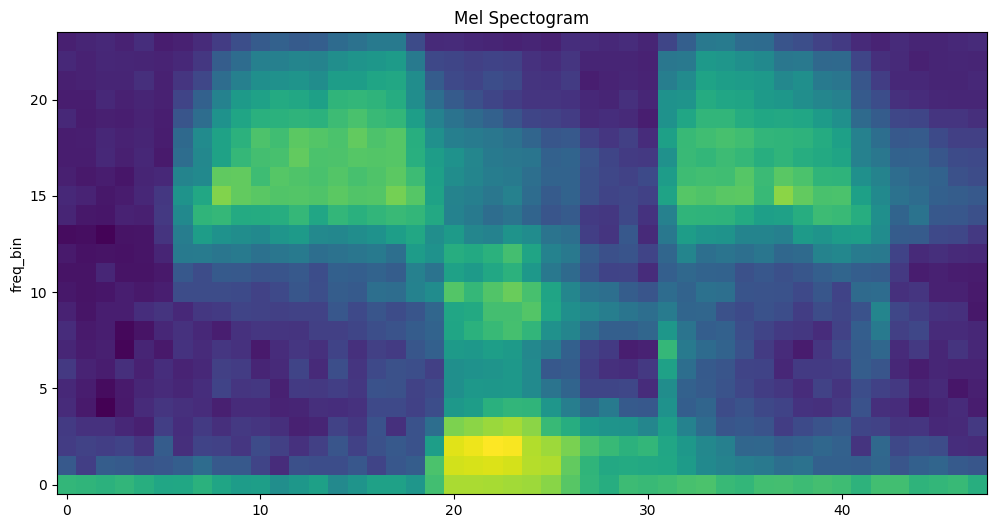

In [29]:
class RawAudioDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __getitem__(self, i):
        path_to_audio, class_label = self.df.iloc[i]
        waveform, _ = torchaudio.load(path_to_audio, normalize=True)

        specgram = self.transform(waveform)

        return specgram, class_label, path_to_audio

    def __len__(self):
        return self.df.shape[0]

ds = RawAudioDataset(audio_df, transform)
sample = ds[29999]
plot_spectogram(sample[0][0], 'Mel Spectogram')
print(f'sample.shape: {sample[0].shape}, sample.class: {sample[1]}')
plt.savefig('sample.png')

## Save dataset to disk

In [30]:
def save_processed_dataset(dataset: RawAudioDataset, output_base_dir: str):
    """
    Processes each item in the dataset and saves the resulting spectrogram tensor
    to files organized by class label and original filename.

    Args:
        dataset: An instance of RawAudioDataset.
        output_base_dir: The base directory where the processed data will be saved.
                         E.g., 'RawFreqMasking'.
    """
    os.makedirs(output_base_dir, exist_ok=True)

    print(f"Saving processed dataset to {os.path.abspath(output_base_dir)}")
    print(f"Total items to process: {len(dataset)}")

    # Iterate through the dataset using tqdm for a progress bar
    # Accessing items via index calls the __getitem__ method
    for i in tqdm(range(len(dataset)), desc="Processing and Saving"):
        item = dataset[i]

        # Check if item is valid (in case of errors handled in __getitem__)
        if item[0] is None:
            continue # Skip this item if there was an error

        specgram, class_label, original_path = item

        # Create the class subdirectory
        # Use str(class_label) to handle potential numeric labels
        class_output_dir = os.path.join(output_base_dir, str(class_label))
        os.makedirs(class_output_dir, exist_ok=True)

        # Generate the output filename based on the original filename
        original_filename = os.path.basename(original_path) # e.g., '0_59_29.wav'
        filename_base, _ = os.path.splitext(original_filename) # e.g., '0_59_29'
        output_filename = f"{filename_base}.pt" # Save as a PyTorch tensor file

        # Create the full path to save the file
        save_path = os.path.join(class_output_dir, output_filename)

        # Save the spectrogram tensor
        try:
            torch.save(specgram, save_path)
        except Exception as e:
             print(f"\nError saving {save_path}: {e}") # Print newline to not mess with tqdm bar


    print("\nDataset saving complete.")

save_processed_dataset(ds, 'RawWithoutDataAugmentation')

Saving processed dataset to /Users/bitfalt/Developer/IA-Project2/notebooks/RawWithoutDataAugmentation
Total items to process: 30000


Processing and Saving: 100%|██████████| 30000/30000 [01:41<00:00, 296.92it/s]


Dataset saving complete.


In [7]:
batch_size = 64

train_ds, val_ds, test_ds = random_split(ds, [0.7, 0.15, 0.15])

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

# Model A (LeNet5)

In [8]:
class LeNet5(torch.nn.Sequential):
    def __init__(self, n_channels, n_classes):
        super().__init__(
            torch.nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=5),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.AvgPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=432, out_features=120),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.Linear(in_features=84, out_features=n_classes)
        )

In [9]:
net = LeNet5(n_channels=n_channels, n_classes=n_classes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

summary(net, (n_channels, n_mels, time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 20, 44]             156
         AvgPool2d-2            [-1, 6, 10, 22]               0
            Conv2d-3            [-1, 16, 6, 18]           2,416
         AvgPool2d-4             [-1, 16, 3, 9]               0
           Flatten-5                  [-1, 432]               0
            Linear-6                  [-1, 120]          51,960
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 65,546
Trainable params: 65,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.25
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [10]:
run = wandb.init(
    entity="bitfalt-itcr",
    project="test-wandb",
    config={
        "learning_rate": 0.0001,
    },
    tags=["LeNet5", "MNIST Audio", "Raw", "Without Data Augmentation"],
    notes="Run with test and val metrics"
)

wandb: Currently logged in as: bitfalt (bitfalt-itcr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [11]:
wandb.watch(net)

In [ ]:
def eval(net, eval_dl, prefix, criterion, metrics, device):
    eval_loss = torch.tensor(0.0).to(device)
    eval_metric_values = {
        metric: torch.zeros(metrics[metric].num_classes if metrics[metric].average is None
                            else 1).to(device) for metric in metrics
    }
    
    net.to(device)
    net.eval()
    with torch.no_grad():
        for X, y in eval_dl:
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)
            
            eval_loss += loss.detach().cpu() * eval_dl.batch_size
            for metric in metrics:
                eval_metric_values[metric] += metrics[metric](preds, y) * \
                    eval_dl.batch_size
    
    eval_loss /= len(eval_dl.dataset)
    for metric in metrics:
        eval_metric_values[metric] /= len(eval_dl.dataset)
    
    print('{}_loss: {:.3f}'.format(prefix, eval_loss), end='')
    for metric in metrics:
        print(', {}_{}: {:.3f}'.format(prefix, metric, eval_metric_values[metric].mean()),
              end='')
        
        if prefix == 'test':
            lossKey = f"{prefix} Loss"
            metricKey = f"{prefix} {metric}"
            wandb.log({
                lossKey: eval_loss,
                metricKey: eval_metric_values[metric].mean(),
            })
    
    return eval_loss, eval_metric_values

In [13]:
def train(net, train_dl, val_dl, n_epochs, criterion, metrics, device, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    history = {
        'train': {'loss': []} | {metric: [] for metric in metrics},
        'val': {'loss': []} | {metric: [] for metric in metrics}
    }
    
    net.to(device)
    for epoch in range(n_epochs):
        train_loss = torch.tensor(0.0).to(device)
        train_metric_values = {
            metric: torch.tensor(0.0).to(device) for metric in metrics
        }
        
        net.train()
        for X, y in tqdm(train_dl, desc='Epoch {}/{}'.format(epoch + 1, n_epochs),
                         total=len(train_dl)):
            X = X.to(device)
            y = y.to(device)
            
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                train_loss += loss.detach().cpu() * train_dl.batch_size
                for metric in metrics:
                    train_metric_values[metric] += train_dl.batch_size * \
                        metrics[metric](preds, y)
        
        train_loss /= len(train_dl.dataset)
        for metric in metrics:
            train_metric_values[metric] /= len(train_dl.dataset)
        
        print('train_loss: {:.3f}'.format(train_loss), end=', ')
        for metric in metrics:
            print('train_{}: {:.3f}'.format(metric, train_metric_values[metric]),
                  end=', ')

            wandb.log({
                "Epoch": epoch,
                "Train Loss": train_loss,
                "Train " + metric: train_metric_values[metric],
            })
        
        history['train']['loss'].append(train_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['train'][metric].append(train_metric_values[metric].cpu().detach() \
                                            .numpy().item())
            
        val_loss, val_metric_values = eval(net, val_dl, prefix='val', criterion=criterion,
                                           metrics=metrics, device=device)
        
        scheduler.step(val_loss)
        
        history['val']['loss'].append(val_loss.cpu().detach().numpy().item())
        for metric in metrics:
            history['val'][metric].append(val_metric_values[metric].cpu().detach() \
                                          .numpy().item())
            wandb.log({
                "Epoch": epoch,
                "Val Loss": val_loss,
                "Val " + metric: val_metric_values[metric],
            })
    return history

In [14]:
criterion = torch.nn.CrossEntropyLoss()

train_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average='macro').to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average='macro').to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average='macro').to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average='macro').to(device)
}

In [15]:
history = train(net, train_dl, val_dl, n_epochs=15, criterion=criterion,
                metrics=train_metrics, device=device, lr=0.0001)

Epoch 1/15: 100%|██████████| 329/329 [00:27<00:00, 12.07it/s]


train_loss: 2.045, train_accuracy: 0.386, train_precision: 0.392, train_recall: 0.386, train_f1-score: 0.322, val_loss: 1.634, val_accuracy: 0.628, val_precision: 0.646, val_recall: 0.628, val_f1-score: 0.588

Epoch 2/15: 100%|██████████| 329/329 [00:24<00:00, 13.45it/s]


train_loss: 1.318, train_accuracy: 0.700, train_precision: 0.721, train_recall: 0.700, train_f1-score: 0.675, val_loss: 1.224, val_accuracy: 0.733, val_precision: 0.768, val_recall: 0.733, val_f1-score: 0.719

Epoch 3/15: 100%|██████████| 329/329 [00:25<00:00, 13.02it/s]


train_loss: 0.999, train_accuracy: 0.771, train_precision: 0.784, train_recall: 0.771, train_f1-score: 0.754, val_loss: 1.094, val_accuracy: 0.783, val_precision: 0.791, val_recall: 0.783, val_f1-score: 0.762

Epoch 4/15: 100%|██████████| 329/329 [00:26<00:00, 12.63it/s]


train_loss: 0.861, train_accuracy: 0.799, train_precision: 0.814, train_recall: 0.799, train_f1-score: 0.787, val_loss: 0.991, val_accuracy: 0.808, val_precision: 0.820, val_recall: 0.808, val_f1-score: 0.797

Epoch 5/15: 100%|██████████| 329/329 [00:26<00:00, 12.47it/s]


train_loss: 0.762, train_accuracy: 0.822, train_precision: 0.830, train_recall: 0.822, train_f1-score: 0.809, val_loss: 1.031, val_accuracy: 0.809, val_precision: 0.821, val_recall: 0.809, val_f1-score: 0.795

Epoch 6/15: 100%|██████████| 329/329 [00:26<00:00, 12.53it/s]


train_loss: 0.708, train_accuracy: 0.836, train_precision: 0.844, train_recall: 0.836, train_f1-score: 0.824, val_loss: 0.975, val_accuracy: 0.835, val_precision: 0.850, val_recall: 0.835, val_f1-score: 0.828

Epoch 7/15: 100%|██████████| 329/329 [00:26<00:00, 12.38it/s]


train_loss: 0.675, train_accuracy: 0.845, train_precision: 0.851, train_recall: 0.845, train_f1-score: 0.834, val_loss: 0.994, val_accuracy: 0.845, val_precision: 0.853, val_recall: 0.845, val_f1-score: 0.836

Epoch 8/15: 100%|██████████| 329/329 [00:26<00:00, 12.38it/s]


train_loss: 0.650, train_accuracy: 0.845, train_precision: 0.851, train_recall: 0.845, train_f1-score: 0.834, val_loss: 0.971, val_accuracy: 0.842, val_precision: 0.858, val_recall: 0.842, val_f1-score: 0.835

Epoch 9/15: 100%|██████████| 329/329 [00:26<00:00, 12.50it/s]


train_loss: 0.622, train_accuracy: 0.856, train_precision: 0.863, train_recall: 0.856, train_f1-score: 0.845, val_loss: 0.979, val_accuracy: 0.858, val_precision: 0.862, val_recall: 0.858, val_f1-score: 0.849

Epoch 10/15: 100%|██████████| 329/329 [00:25<00:00, 12.69it/s]


train_loss: 0.592, train_accuracy: 0.863, train_precision: 0.864, train_recall: 0.863, train_f1-score: 0.850, val_loss: 1.004, val_accuracy: 0.859, val_precision: 0.864, val_recall: 0.859, val_f1-score: 0.850

Epoch 11/15: 100%|██████████| 329/329 [00:25<00:00, 12.98it/s]


train_loss: 0.579, train_accuracy: 0.865, train_precision: 0.871, train_recall: 0.865, train_f1-score: 0.856, val_loss: 1.008, val_accuracy: 0.865, val_precision: 0.875, val_recall: 0.865, val_f1-score: 0.859

Epoch 12/15: 100%|██████████| 329/329 [00:26<00:00, 12.32it/s]


train_loss: 0.547, train_accuracy: 0.873, train_precision: 0.878, train_recall: 0.873, train_f1-score: 0.865, val_loss: 1.006, val_accuracy: 0.879, val_precision: 0.881, val_recall: 0.879, val_f1-score: 0.871

Epoch 13/15: 100%|██████████| 329/329 [00:26<00:00, 12.30it/s]


train_loss: 0.538, train_accuracy: 0.882, train_precision: 0.881, train_recall: 0.882, train_f1-score: 0.870, val_loss: 1.019, val_accuracy: 0.877, val_precision: 0.881, val_recall: 0.877, val_f1-score: 0.869

Epoch 14/15: 100%|██████████| 329/329 [00:26<00:00, 12.56it/s]


train_loss: 0.518, train_accuracy: 0.880, train_precision: 0.884, train_recall: 0.880, train_f1-score: 0.871, val_loss: 1.028, val_accuracy: 0.878, val_precision: 0.883, val_recall: 0.878, val_f1-score: 0.871

Epoch 15/15: 100%|██████████| 329/329 [00:26<00:00, 12.22it/s]


train_loss: 0.518, train_accuracy: 0.882, train_precision: 0.884, train_recall: 0.882, train_f1-score: 0.872, val_loss: 1.036, val_accuracy: 0.877, val_precision: 0.881, val_recall: 0.877, val_f1-score: 0.869

# Plot history

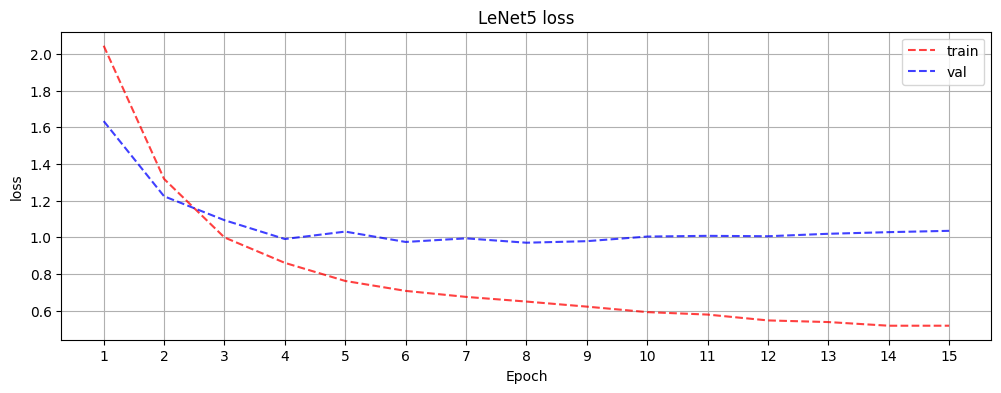

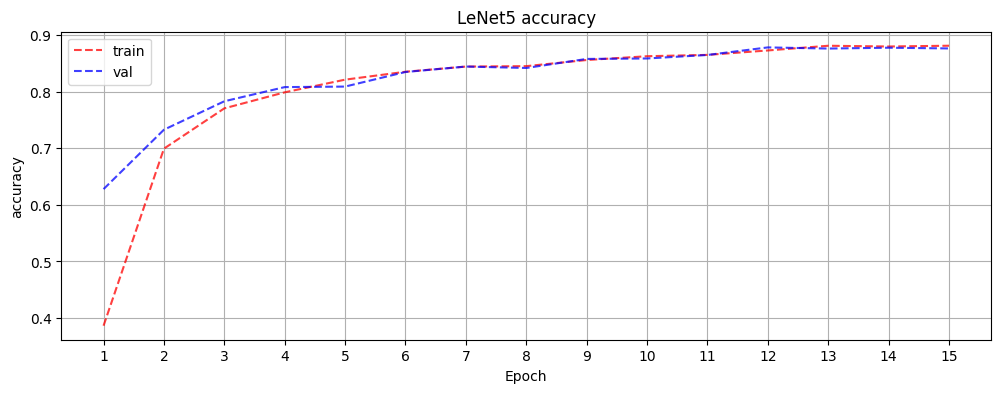

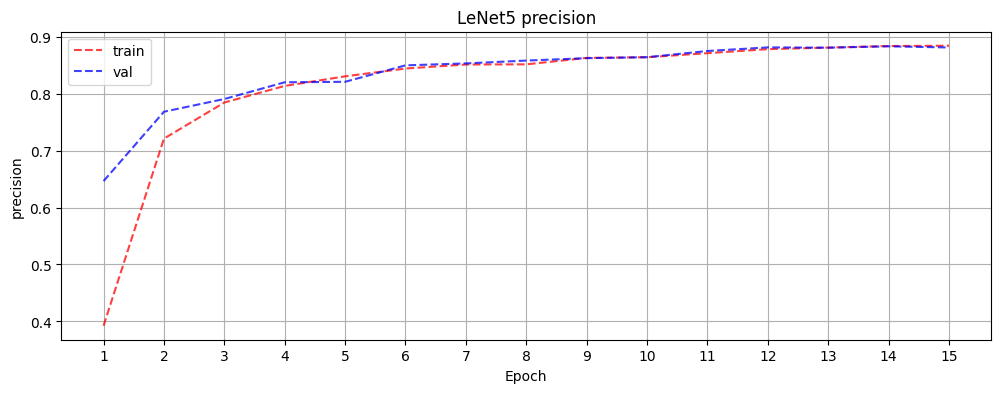

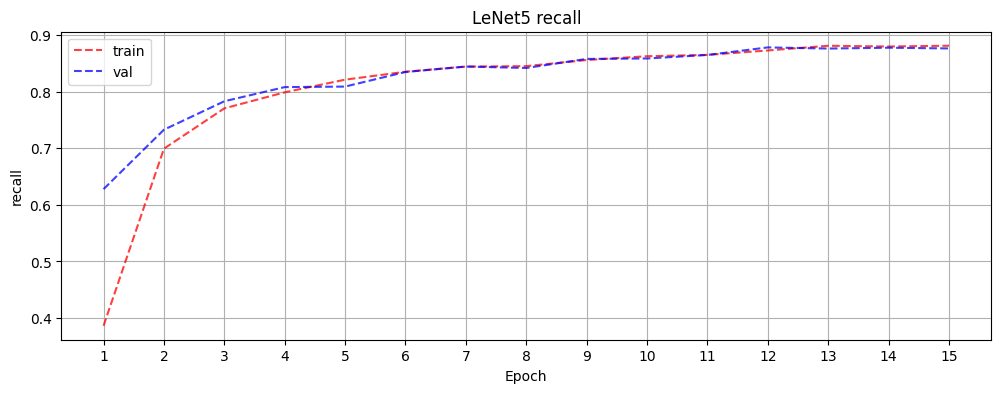

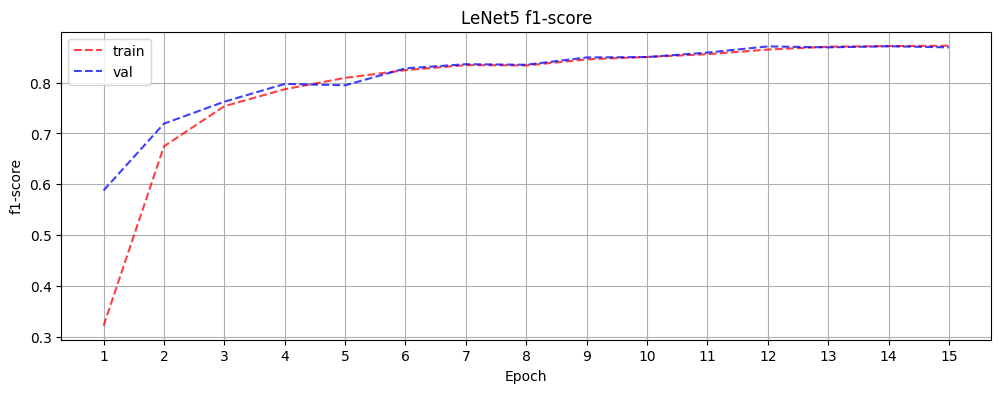

In [16]:
plot_history(history, net_name='LeNet5')


# Evaluate neural network

In [17]:
test_metrics = {
    'accuracy': Accuracy(task='multiclass', num_classes=int(n_classes),
                         average=None).to(device),
    'precision': Precision(task='multiclass', num_classes=int(n_classes),
                           average=None).to(device),
    'recall': Recall(task='multiclass', num_classes=int(n_classes),
                     average=None).to(device),
    'f1-score': F1Score(task='multiclass', num_classes=int(n_classes),
                        average=None).to(device)
}

In [18]:
_, test_metric_values = eval(net, test_dl, prefix='test', criterion=criterion,
                             metrics=test_metrics, device=device)

test_loss: 0.619, test_accuracy: 0.873, test_precision: 0.873, test_recall: 0.873, test_f1-score: 0.861

In [ ]:
plot_metric_values(test_metric_values, net_name='LeNet5')